In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Layer, add, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D, Reshape, Dense, Multiply, concatenate, Concatenate, Conv2DTranspose, Input, MaxPool2D, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from transformers import TFAutoModel

In [7]:
# Print versions
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("OpenCV version:", cv2.__version__)
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)  # Keras is integrated within TensorFlow

NumPy version: 1.26.3
Pandas version: 2.2.2
OpenCV version: 4.10.0
TensorFlow version: 2.17.0
Keras version: 3.5.0


In [2]:
def load_data(images_dir, masks_dir):
    # Initialize lists to hold images and masks
    images_list = []
    masks_list = []

    # Fetch and sort image and mask file paths
    image_paths = sorted(glob.glob(images_dir))
    mask_paths = sorted(glob.glob(masks_dir))

    # Process each image and corresponding mask
    for img_path, msk_path in zip(image_paths, mask_paths):
        # Load and preprocess image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64))
        img = img.astype('float32') / 255.0
        images_list.append(img)

        # Load and preprocess mask
        msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)
        msk = cv2.resize(msk, (64, 64), interpolation=cv2.INTER_NEAREST)
        msk = msk.astype('float32') / 255.0
        msk = np.expand_dims(msk, axis=-1)
        masks_list.append(msk)

    return np.array(images_list), np.array(masks_list)

# Dataset paths
dataset_paths = {
    'REFUGE': {
        'images': './archive/REFUGE/train/Images_Cropped/*.jpg',
        'masks': './archive/REFUGE/train/Masks_Cropped/*.png'
    },
    'ORIGA': {
        'images': './archive/ORIGA/Images_Cropped/*.jpg',
        'masks': './archive/ORIGA/Masks_Cropped/*.png'
    },
    'G1020': {
        'images': './archive/G1020/Images_Cropped/img/*.jpg',
        'masks': './archive/G1020/Masks_Cropped/img/*.png'
    }
}

# Aggregate all images and masks
all_images = []
all_masks = []

for paths in dataset_paths.values():
    imgs, msks = load_data(paths['images'], paths['masks'])
    all_images.extend(imgs)
    all_masks.extend(msks)

# Convert lists to numpy arrays
images_array = np.array(all_images)
masks_array = np.array(all_masks, dtype='float32')

# Initialize label encoder
encoder = LabelEncoder()

# Reshape masks and encode labels
num_imgs, num_channels, img_height, img_width = masks_array.shape
flattened_masks = masks_array.reshape(-1, 1)
encoded_masks = encoder.fit_transform(flattened_masks.ravel())

# Reshape encoded masks back to original dimensions
reshaped_encoded_masks = encoded_masks.reshape(num_imgs, num_channels, img_height, img_width)

# Convert masks to categorical format
num_classes = 3
categorical_masks = to_categorical(reshaped_encoded_masks, num_classes=num_classes)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_array, categorical_masks, test_size=0.20)

# Output the shapes of the datasets
print(f"Training images shape: {X_train.shape}")
print(f"Testing images shape: {X_test.shape}")
print(f"Training masks shape: {y_train.shape}")
print(f"Testing masks shape: {y_test.shape}")

Training images shape: (1656, 64, 64, 3)
Testing images shape: (414, 64, 64, 3)
Training masks shape: (1656, 64, 64, 3)
Testing masks shape: (414, 64, 64, 3)


In [10]:
from __future__ import absolute_import

from keras_unet_collection.layer_utils import *
from keras_unet_collection.activations import GELU, Snake
from keras_unet_collection._model_unet_2d import UNET_left, UNET_right
from keras_unet_collection.transformer_layers import patch_extract, patch_embedding
from keras_unet_collection._backbone_zoo import backbone_zoo, bach_norm_checker

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, Dense, Embedding

class ReduceMeanLayer(Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=-1, keepdims=True)

class ReduceMaxLayer(Layer):
    def call(self, inputs):
        return tf.reduce_max(inputs, axis=-1, keepdims=True)

def cbam_block(input_tensor, ratio=8):
    """Creates a CBAM block."""
    # Channel Attention Module
    channel = input_tensor.shape[-1]
    shared_layer_one = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_tensor)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_tensor)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = Activation('sigmoid')(avg_pool + max_pool)
    cbam_feature = Multiply()([input_tensor, cbam_feature])

    # Spatial Attention Module
    avg_pool = ReduceMeanLayer()(cbam_feature)  # Use custom layer
    max_pool = ReduceMaxLayer()(cbam_feature)   # Use custom layer
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    cbam_feature = Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    cbam_feature = Multiply()([cbam_feature, input_tensor])

    return cbam_feature

def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if activation is None:
        return x

    x = Activation(activation, name=name)(x)
    return x

def DCBlock(U, inp, alpha=1.67):
    W = alpha * U

    conv3x3_1 = conv2d_bn(inp, int(W * 0.167), 3, 3, activation='relu', padding='same')
    conv5x5_1 = conv2d_bn(conv3x3_1, int(W * 0.333), 3, 3, activation='relu', padding='same')
    conv7x7_1 = conv2d_bn(conv5x5_1, int(W * 0.5), 3, 3, activation='relu', padding='same')

    out1 = concatenate([conv3x3_1, conv5x5_1, conv7x7_1], axis=3)
    out1 = BatchNormalization(axis=3)(out1)

    conv3x3_2 = conv2d_bn(inp, int(W * 0.167), 3, 3, activation='relu', padding='same')
    conv5x5_2 = conv2d_bn(conv3x3_2, int(W * 0.333), 3, 3, activation='relu', padding='same')
    conv7x7_2 = conv2d_bn(conv5x5_2, int(W * 0.5), 3, 3, activation='relu', padding='same')

    out2 = concatenate([conv3x3_2, conv5x5_2, conv7x7_2], axis=3)
    out2 = BatchNormalization(axis=3)(out2)

    out = add([out1, out2])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    # Apply CBAM block after the DC block operations
    out = cbam_block(out)

    return out
    
def Transformer_MLP(input_tensor, mlp_filters, activation_func='GELU', block_name='MLP_Block'):
    act_func = eval(activation_func)
    
    for idx, filters in enumerate(mlp_filters):
        input_tensor = Dense(filters, name='{}_dense_{}'.format(block_name, idx))(input_tensor)
        input_tensor = act_func(name='{}_activation_{}'.format(block_name, idx))(input_tensor)
        
    return input_tensor
    
def Transformer_block(inputs, attention_heads, key_dimension, mlp_filters, activation_func='GELU', block_name='Transformer'):
    # Multi-headed self-attention (MSA)
    attention_output = inputs  # <--- skip connection
    attention_output = LayerNormalization(name='{}_layer_norm_1'.format(block_name))(attention_output)
    attention_output = MultiHeadAttention(num_heads=attention_heads, key_dim=key_dimension, 
                                          name='{}_attention'.format(block_name))(attention_output, attention_output)
    # Skip connection
    skip_connection_1 = add([attention_output, inputs], name='{}_skip_1'.format(block_name))  # <--- skip connection
    
    # MLP
    mlp_output = skip_connection_1  # <--- skip connection
    mlp_output = LayerNormalization(name='{}_layer_norm_2'.format(block_name))(mlp_output)
    mlp_output = Transformer_MLP(mlp_output, mlp_filters, activation_func, block_name='{}_mlp'.format(block_name))
    
    # Skip connection
    final_output = add([mlp_output, skip_connection_1], name='{}_skip_2'.format(block_name))  # <--- skip connection
    
    return final_output


def transunet_v2_base(input_layer, conv_filters, num_down_blocks=2, num_up_blocks=2, 
                      embedding_dim=768, mlp_units=3072, num_attention_heads=12, num_transformer_blocks=12,
                      activation_func='ReLU', mlp_activation_func='GELU', use_batch_norm=False, use_pooling=True, use_unpooling=True, 
                      backbone_model=None, pretrained_weights='imagenet', freeze_base_model=True, freeze_bn=True, model_name='transunet_v2'):
    
    act_func = eval(activation_func)
    
    skip_connections = []
    depth = len(conv_filters)
    
    # ----- internal parameters ----- #
    
    patch_size = 1
    input_shape = input_layer.shape[1]
    feature_map_size = input_shape // 2**(depth-1)
    total_patches = feature_map_size ** 2
    key_dim = embedding_dim
    mlp_filter_sizes = [mlp_units, embedding_dim]
    
    # ----- UNet-like downsampling ----- #
    
    if backbone_model is None:

        x = input_layer

        # stacked conv2d before downsampling
        x = CONV_stack(x, conv_filters[0], stack_num=num_down_blocks, activation=activation_func, 
                       batch_norm=use_batch_norm, name='{}_down0'.format(model_name))
        skip_connections.append(x)

        # downsampling blocks
        for idx, filters in enumerate(conv_filters[1:]):
            x = UNET_left(x, filters, stack_num=num_down_blocks, activation=activation_func, pool=use_pooling, 
                                batch_norm=use_batch_norm, name='{}_down{}'.format(model_name, idx+1))        
            skip_connections.append(x)

    else:
        if 'VGG' in backbone_model:
            backbone_output = backbone_zoo(backbone_model, pretrained_weights, input_layer, depth, freeze_base_model, freeze_bn)
            skip_connections = backbone_output([input_layer,])
            encoding_depth = len(skip_connections)
        else:
            backbone_output = backbone_zoo(backbone_model, pretrained_weights, input_layer, depth-1, freeze_base_model, freeze_bn)
            skip_connections = backbone_output([input_layer,])
            encoding_depth = len(skip_connections) + 1

        if encoding_depth < depth:
            x = skip_connections[-1]

            for i in range(depth - encoding_depth):
                real_idx = i + encoding_depth
                x = UNET_left(x, conv_filters[real_idx], stack_num=num_down_blocks, activation=activation_func, pool=use_pooling, 
                                batch_norm=use_batch_norm, name='{}_down{}'.format(model_name, real_idx + 1))
                skip_connections.append(x)
        
    x = skip_connections[-1]
    skip_connections = skip_connections[:-1]

    x = DCBlock(512, x)

    x = Conv2D(conv_filters[-1], 1, padding='valid', use_bias=False, name='{}_conv_trans_before'.format(model_name))(x)

    x = patch_extract((patch_size, patch_size))(x)
    x = patch_embedding(total_patches, embedding_dim)(x)

    for i in range(num_transformer_blocks):
        x = Transformer_block(x, num_attention_heads, key_dim, mlp_filter_sizes, activation_func=mlp_activation_func, 
                              block_name='{}_transformer_{}'.format(model_name, i))

    x = tf.keras.layers.Reshape((feature_map_size, feature_map_size, embedding_dim))(x)
    x = Conv2D(conv_filters[-1], 1, padding='valid', use_bias=False, name='{}_conv_trans_after'.format(model_name))(x)
    skip_connections.append(x)
    
    # ----- UNet-like upsampling ----- #
    
    skip_connections = skip_connections[::-1]
    x = skip_connections[0]
    decoded_layers = skip_connections[1:]
    decode_depth = len(decoded_layers)
    decode_filters = conv_filters[:-1][::-1]

    for i in range(decode_depth):
        x = UNET_right(x, [decoded_layers[i],], decode_filters[i], stack_num=num_up_blocks, activation=activation_func, 
                          unpool=use_unpooling, batch_norm=use_batch_norm, name='{}_up{}'.format(model_name, i))

    if decode_depth < depth-1:
        for i in range(depth - decode_depth - 1):
            real_idx = i + decode_depth
            x = UNET_right(x, None, decode_filters[real_idx], stack_num=num_up_blocks, activation=activation_func, 
                          unpool=use_unpooling, batch_norm=use_batch_norm, concat=False, name='{}_up{}'.format(model_name, real_idx))
            
    return x

def transunet_v2(input_shape, conv_filters, num_classes, num_down_blocks=2, num_up_blocks=2,
                 embedding_dim=768, mlp_units=3072, num_attention_heads=12, num_transformer_blocks=12,
                 activation_func='ReLU', mlp_activation_func='GELU', output_activation_func='Softmax', use_batch_norm=False, use_pooling=True, use_unpooling=True, 
                 backbone_model=None, pretrained_weights='imagenet', freeze_base_model=True, freeze_bn=True, model_name='transunet_v2'):
    
    act_func = eval(activation_func)
        
    input_layer = Input(input_shape)
    
    base_output = transunet_v2_base(input_layer, conv_filters, num_down_blocks=num_down_blocks, num_up_blocks=num_up_blocks, 
                                    embedding_dim=embedding_dim, mlp_units=mlp_units, num_attention_heads=num_attention_heads, num_transformer_blocks=num_transformer_blocks,
                                    activation_func=activation_func, mlp_activation_func=mlp_activation_func, use_batch_norm=use_batch_norm, use_pooling=use_pooling, use_unpooling=use_unpooling,
                                    backbone_model=backbone_model, pretrained_weights=pretrained_weights, freeze_base_model=freeze_base_model, freeze_bn=freeze_bn, model_name=model_name)
    
    output_layer = CONV_output(base_output, num_classes, kernel_size=1, activation=output_activation_func, name='{}_output'.format(model_name))
    
    model = Model(inputs=[input_layer,], outputs=[output_layer,], name='{}_model'.format(model_name))
    
    return model

def iou_metric(y_true, y_pred):
    """Calculate Intersection over Union (IoU)."""
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.bool)
    
    intersection = tf.reduce_sum(tf.cast(tf.logical_and(y_true, y_pred), tf.float32))
    union = tf.reduce_sum(tf.cast(tf.logical_or(y_true, y_pred), tf.float32))
    
    return intersection / (union + tf.keras.backend.epsilon())

def dice_coefficient(y_true, y_pred):
    """Calculate Dice Coefficient."""
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + tf.keras.backend.epsilon()) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + tf.keras.backend.epsilon())

input_size = (64, 64, 3)  # Adjust based on your dataset
filter_num = [32, 64, 128, 256]  # Example filter numbers
n_labels = 3  # For binary segmentation; adjust for multi-class

model = transunet_v2(input_size, filter_num, n_labels)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',  # Change if necessary
              metrics=['accuracy', iou_metric, dice_coefficient])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    batch_size=16,  # Adjust based on your memory
                    epochs=10)  # Adjust based on your needs


Epoch 1/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 853s 8s/step - accuracy: 0.6186 - dice_coefficient: 0.5259 - iou_metric: 0.3824 - loss: 1.0497 - val_accuracy: 0.6105 - val_dice_coefficient: 0.5144 - val_iou_metric: 0.4404 - val_loss: 0.9234
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 824s 8s/step - accuracy: 0.7990 - dice_coefficient: 0.7154 - iou_metric: 0.6666 - loss: 0.4577 - val_accuracy: 0.6396 - val_dice_coefficient: 0.6044 - val_iou_metric: 0.4707 - val_loss: 0.8802
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 827s 8s/step - accuracy: 0.8232 - dice_coefficient: 0.7501 - iou_metric: 0.7005 - loss: 0.4140 - val_accuracy: 0.7304 - val_dice_coefficient: 0.6537 - val_iou_metric: 0.5732 - val_loss: 0.6018
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 826s 8s/step - accuracy: 0.7113 - dice_coefficient: 0.6423 - iou_metric: 0.5488 - loss: 0.6209 - val_accuracy: 0.8018 - val_dice_coefficient: 0.7370 - val_iou_metric: 0.6691 - val_loss: 0.4406
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 825s 8s/step - accuracy: 0.8

In [11]:
# Evaluate the U-Net model on the test data
evaluation_metrics = model.evaluate(X_test, y_test)

# Extract accuracy, IoU, and Dice Coefficient from the evaluation metrics
accuracy = evaluation_metrics[1] * 100
iou = evaluation_metrics[2] * 100  # Assuming IoU is at index 4
dice = evaluation_metrics[3] * 100  # Assuming Dice Coefficient is at index 5

# Print the accuracy, IoU, and Dice Coefficient in formatted strings
print(f"Test Accuracy: {accuracy:.4f}%")
print(f"Test IoU: {iou:.4f}%")
print(f"Test Dice Coefficient: {dice:.4f}%")


13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8509 - dice_coefficient: 0.7765 - iou_metric: 0.7403 - loss: 0.3563
Test Accuracy: 84.9849%
Test IoU: 73.8578%
Test Dice Coefficient: 77.5759%


13/13 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step


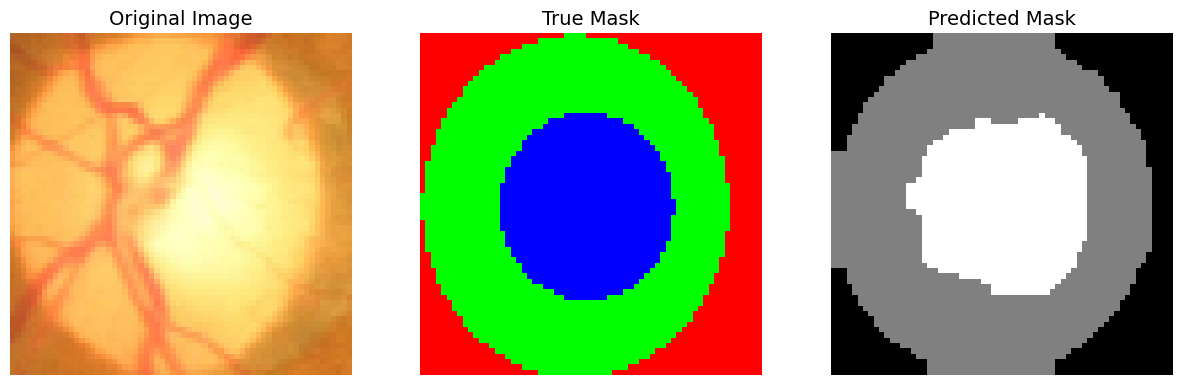

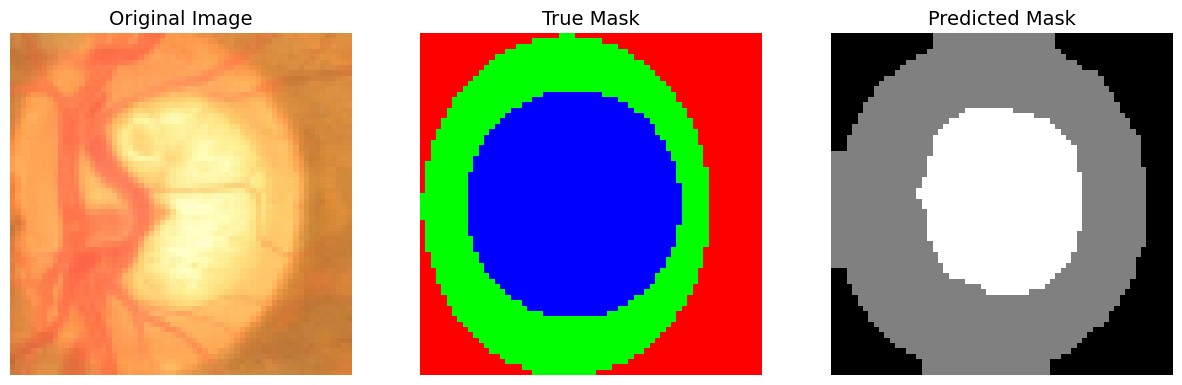

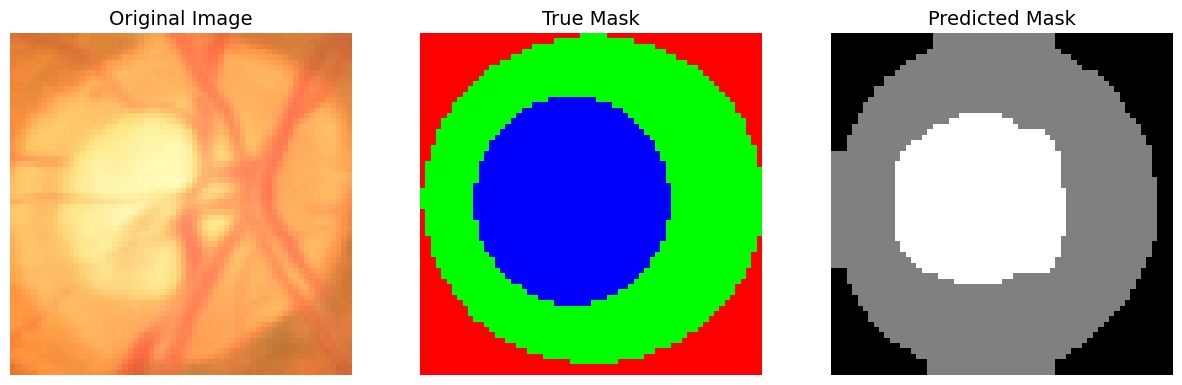

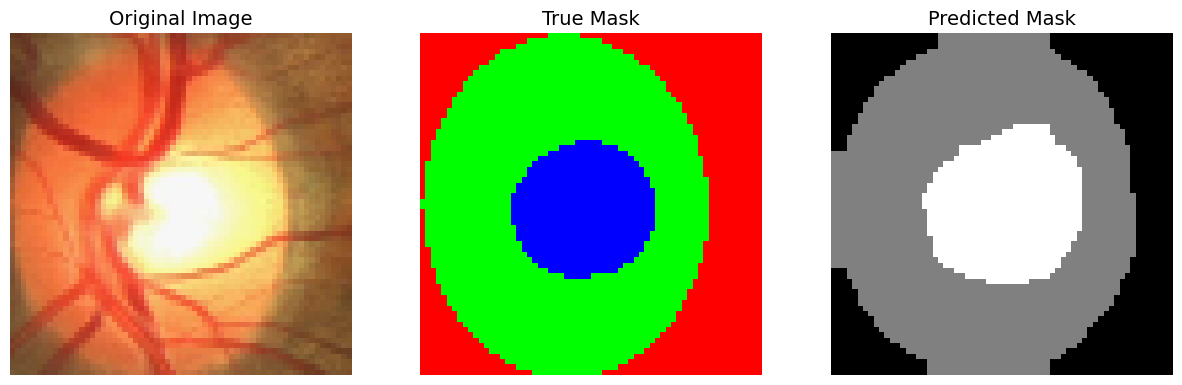

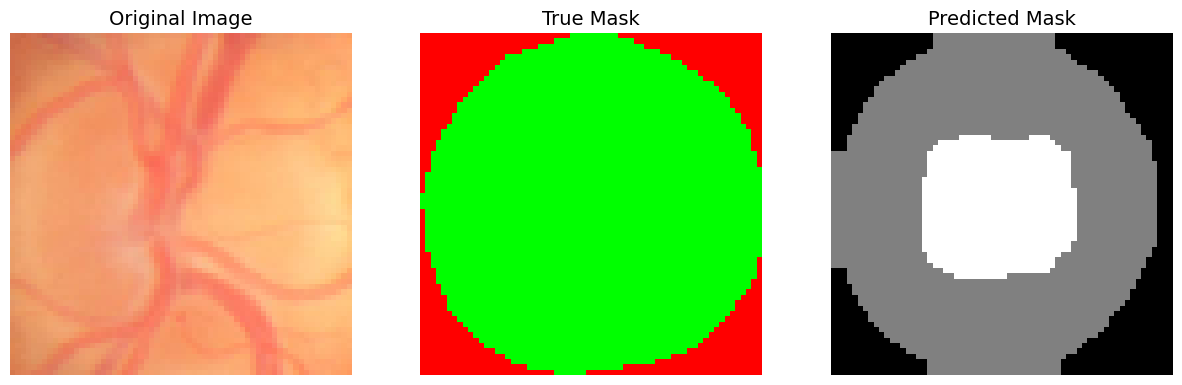

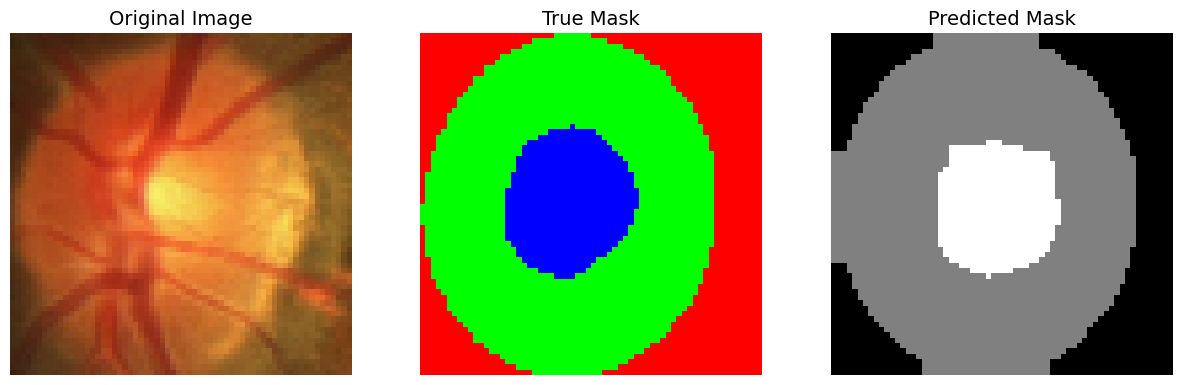

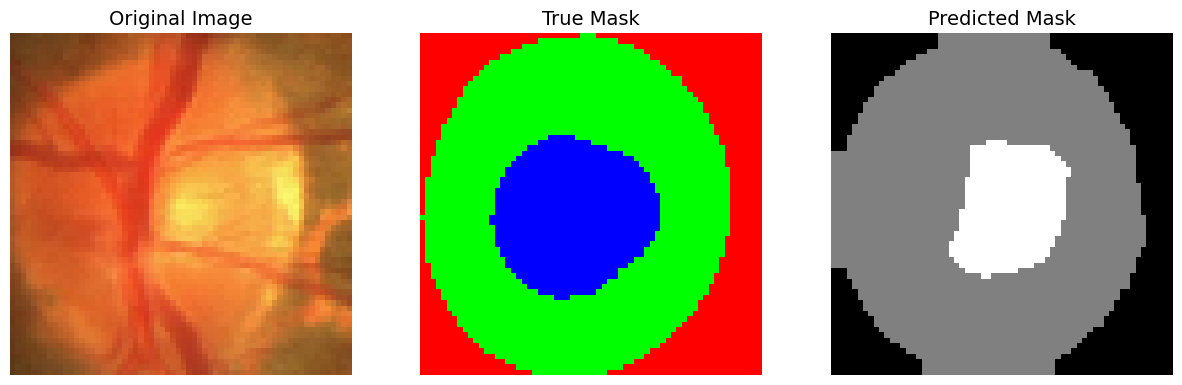

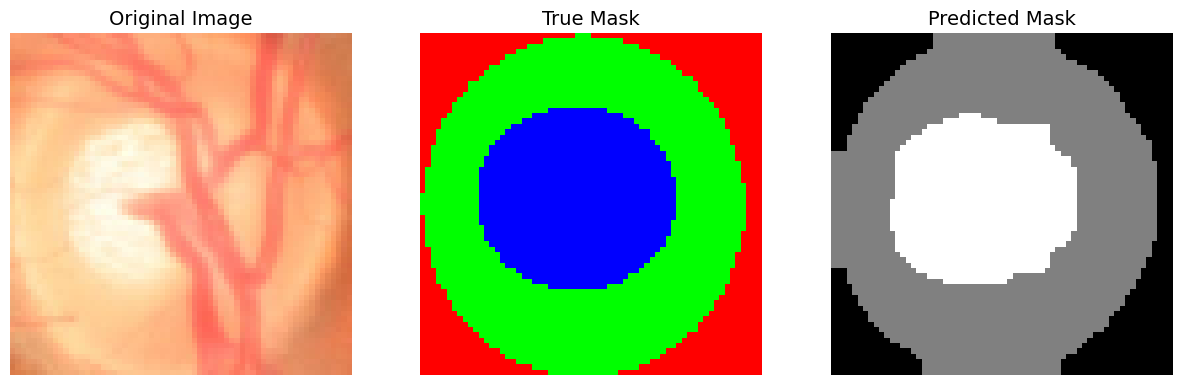

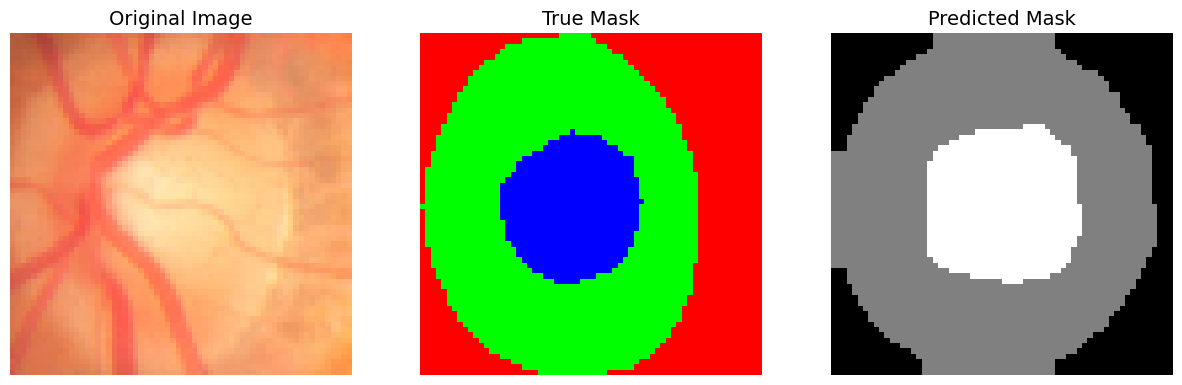

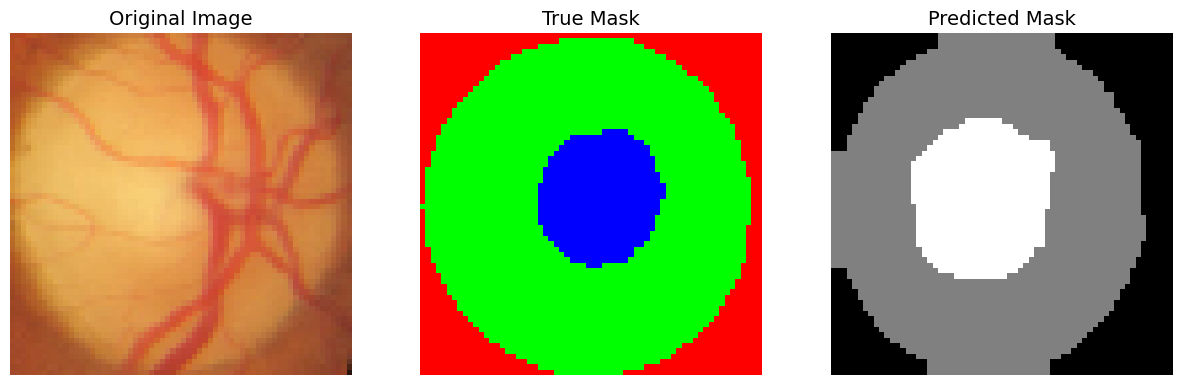

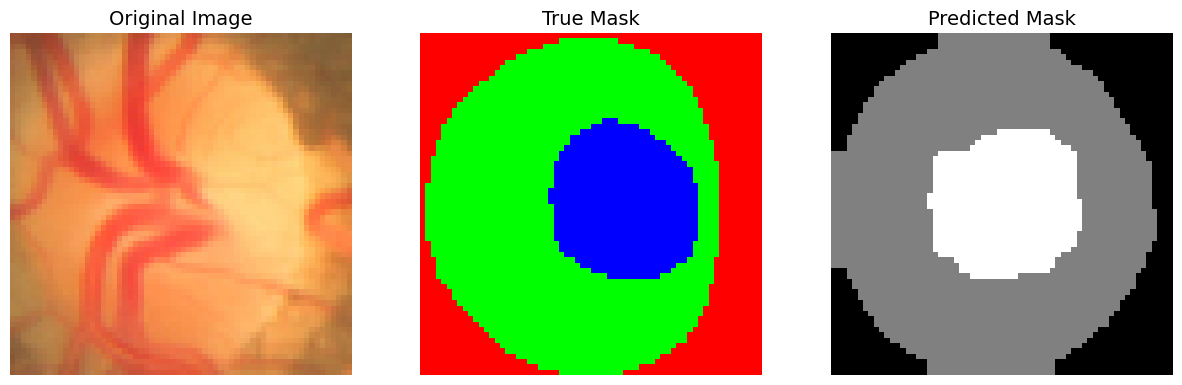

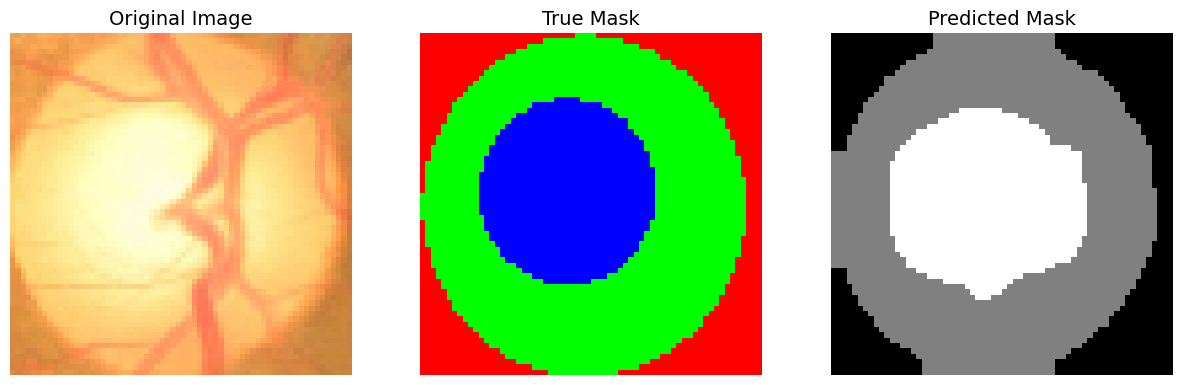

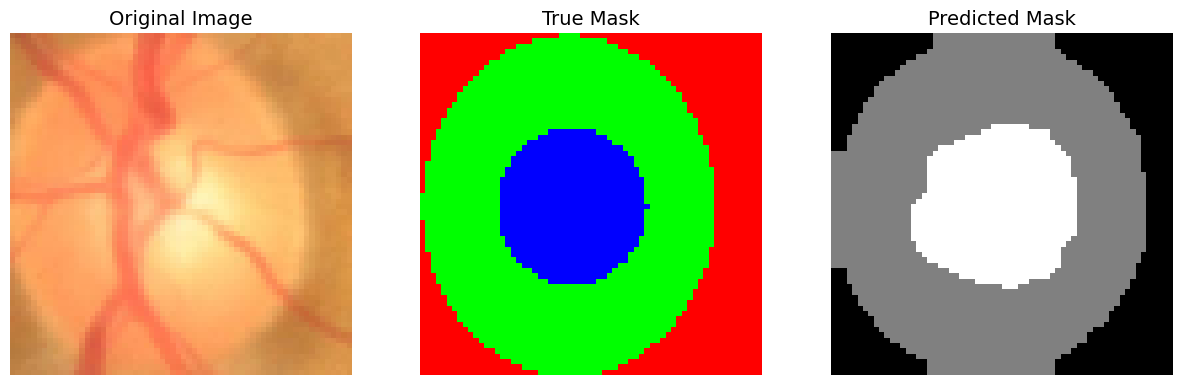

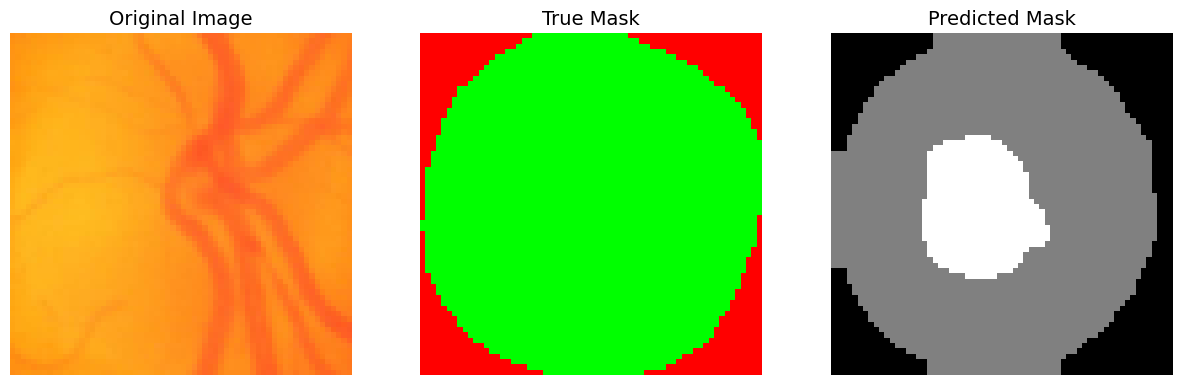

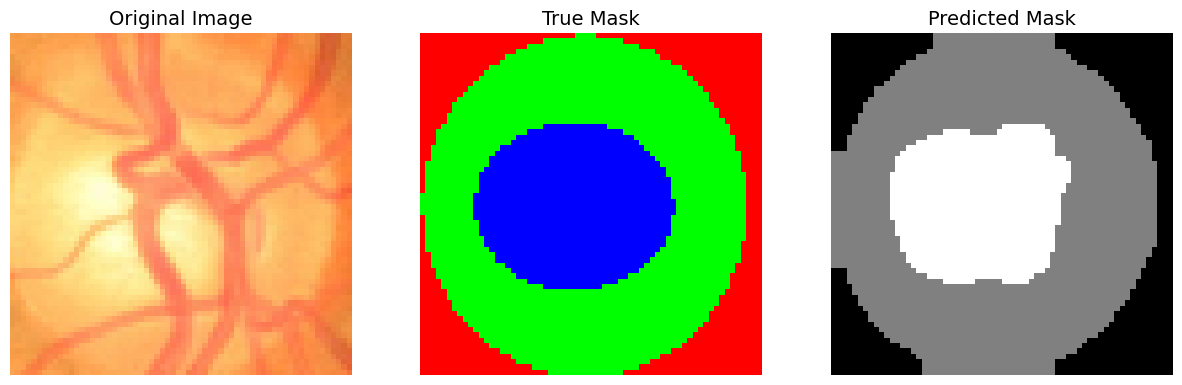

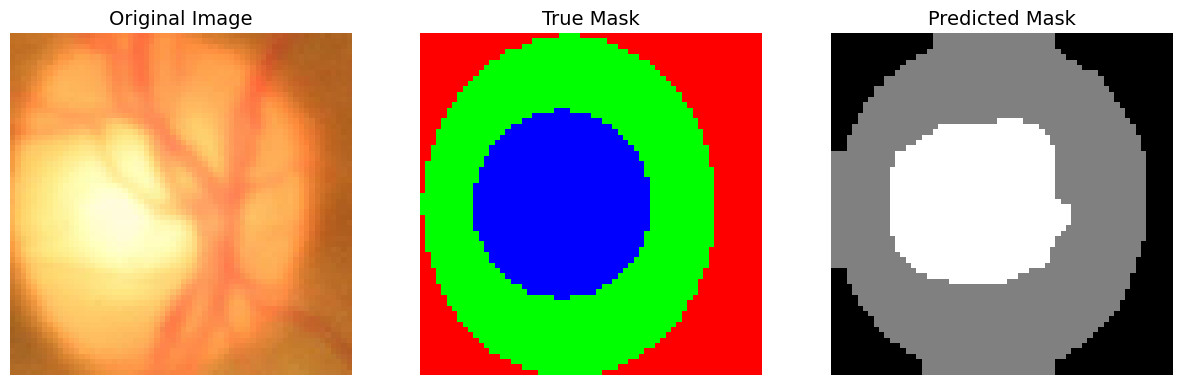

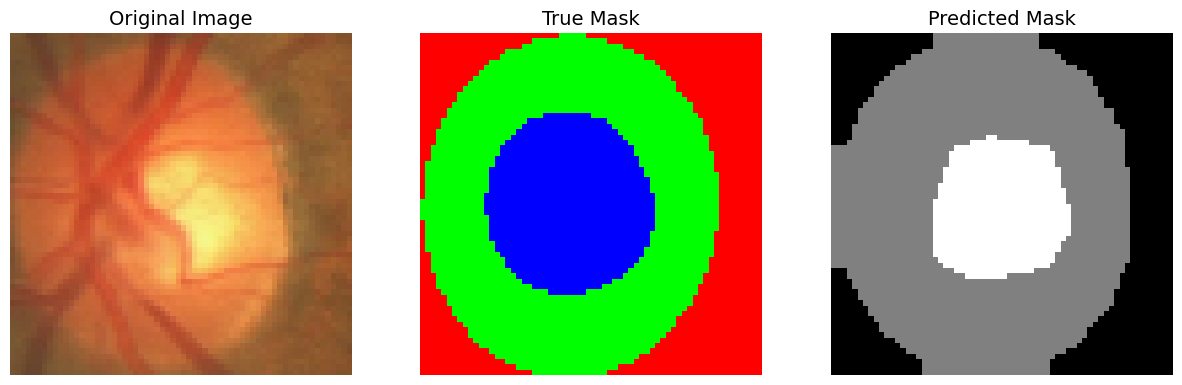

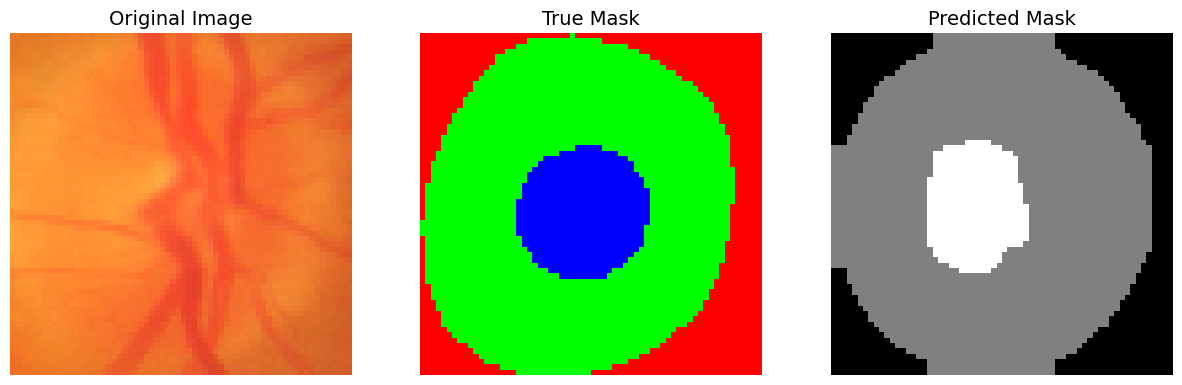

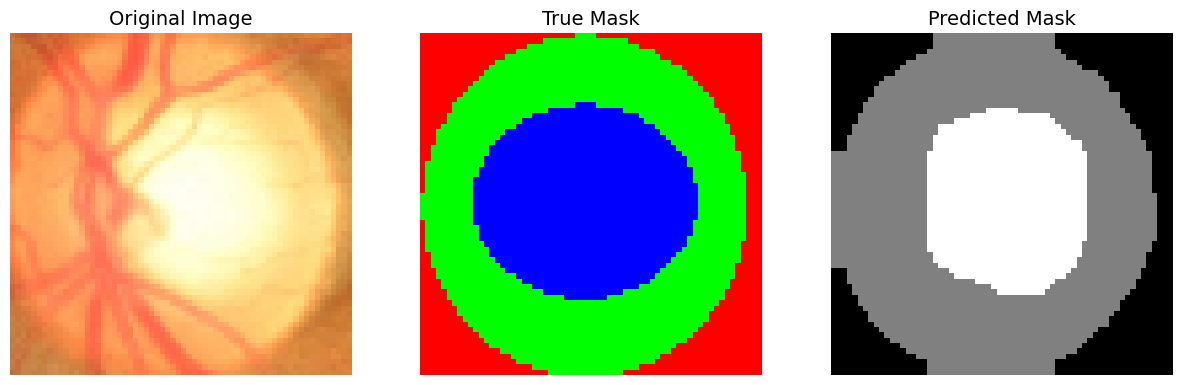

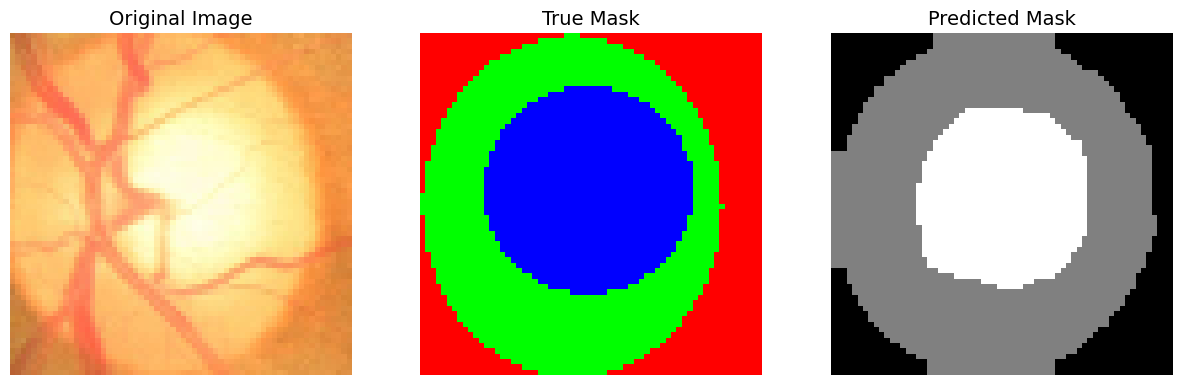

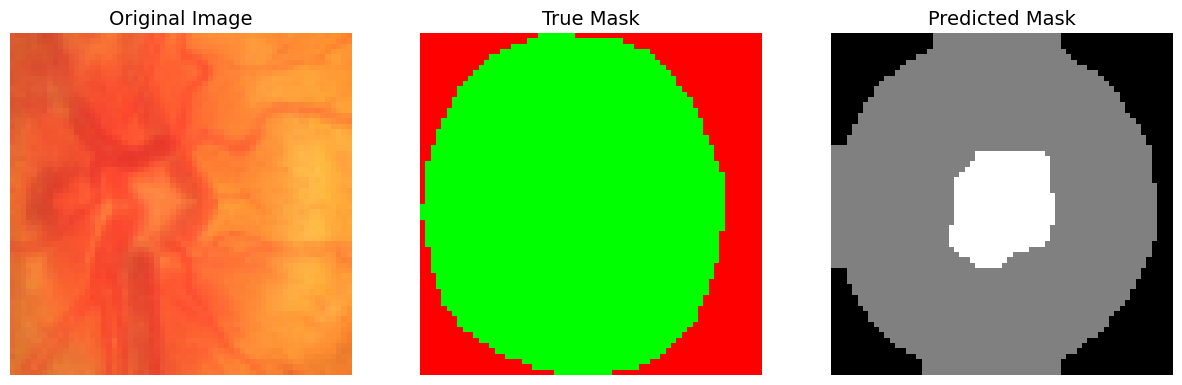

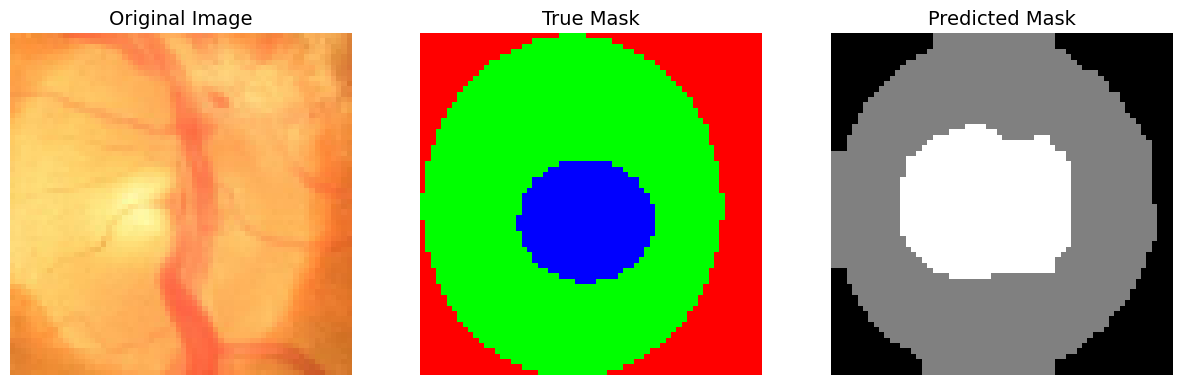

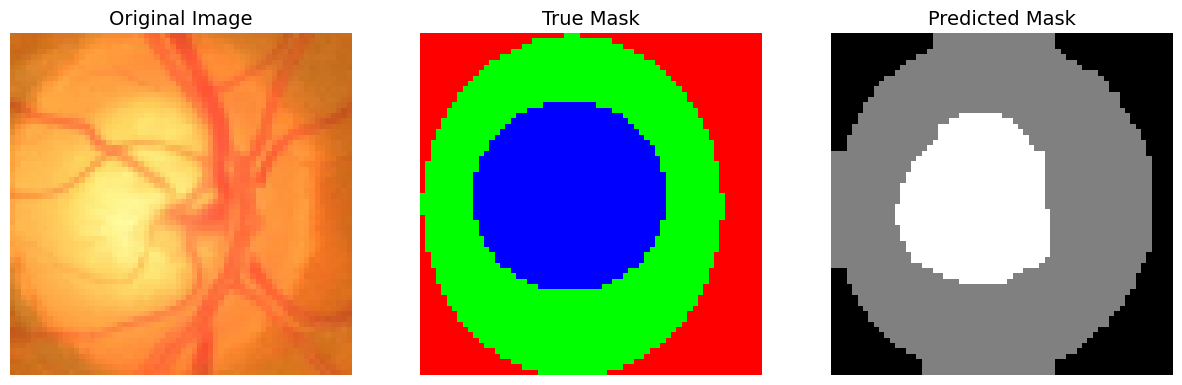

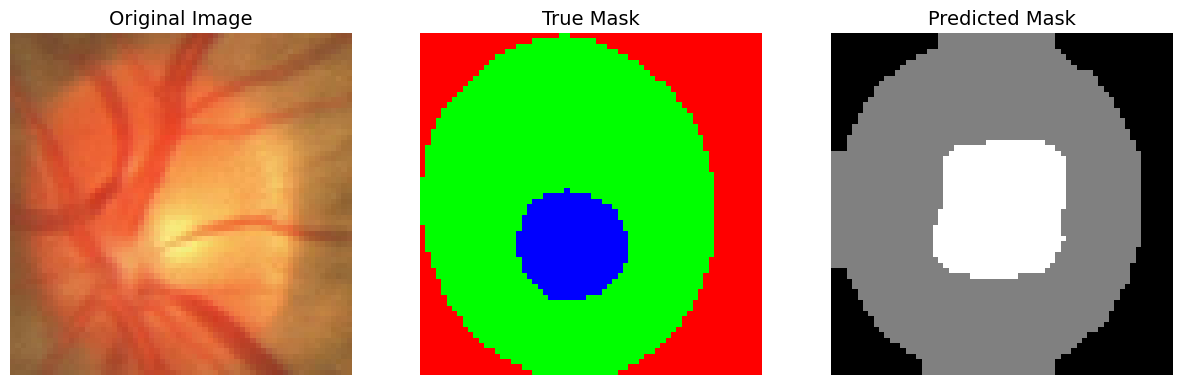

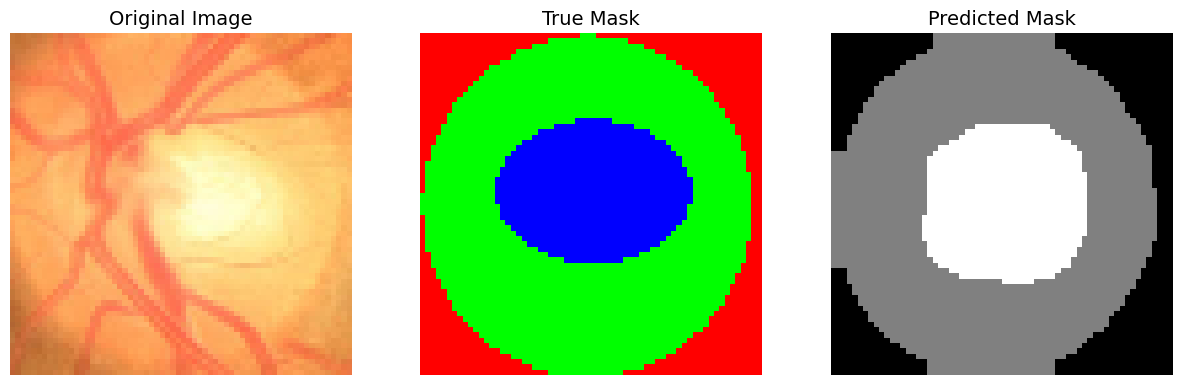

In [12]:
def perform_morphological_closing(image, kernel_shape=(5, 5)):
    """Apply morphological closing operation to the input image."""
    kernel = np.ones(kernel_shape, dtype=np.uint8)
    closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    return closed_image

# Generate predictions from the U-Net model
predicted_probs = model.predict(X_test)

# Convert predicted probabilities to binary masks
predicted_labels = np.argmax(predicted_probs, axis=-1).astype(np.uint8)

# Display results for the first 25 images
for idx in range(25):
    img = X_test[idx]
    true_mask = y_test[idx, :, :]
    pred_mask = predicted_labels[idx]

    # Apply morphological closing to the predicted mask
    closed_pred_mask = perform_morphological_closing(pred_mask)

    # Plot the images and masks
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image', fontsize=14)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask)
    plt.title('True Mask', fontsize=14)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(closed_pred_mask, cmap='grey')
    plt.title('Predicted Mask', fontsize=14)
    plt.axis('off')

    plt.show()